# ARPA Lombardia - Meteorological Stations Data Request and Processing Notebook

This notebook allows to access to ARPA Lombardia meteorological stations using the datasets freely available on [Open Data Regione Lombardia Catalog](https://dati.lombardia.it/).

## Datasets organization and description

Firstly, it is necessary to understand the organization of the available datasets.<br>
The dataset that will be used in this notebook are:
1. Sensors information
2. Time-series measured by each sensor

By merging this datasets on the Sensor ID column it is possible to combine the information.

### 1. Sensors Information

The information about each sensor in ARPA's weather monitoring network (~ 1200/1300 sensors) are available at the following can be obtained directly from the API (Application Programming Interface), allowing a systematic way to request the data from the catalog. These information are provided separately from the sensors measured time-series.<br> 
<br> 
Link to the resource: https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b


The sensors information accessible through this portal include:
| Information description | Column Name |
| :---: | :---: |
| ID of the sensor | idsensore |
| Type of the Sensor | tipologia |
| Measure Unit | unit_dimisura |
| Station ID (multiple sensors can be available at the same station | idstazione |
| Name of the Station | nomestazione |
| Height of the station (m) | quota |
| Start date of the time-series | datastart |
| Whether the sensor is historical | storico |
| WGS84 UTM 32N North Coordinate | cgb_nord |
| WGS84 UTM 32N East Coordinate | cgb_est |
| Longitude | lng |
| Latitude | lat |
| Dictionary containing latitude and longitude | location |
| Eventual end date of the time-series, if the sensor is not measuring | datastop |

Specifically, the following  are the types of sensors available in the ARPA Meteorological Network:

| Sensor Type | Sensor Name | Measure Unit |
| :---: | :---: | :---: |
| Rainfall | Precipitazione | mm |
| Temperature | Temperatura | °C |
| Relative Humidity | Umidità Relativa | % |
| Global Solar Radiation | Radiazione Globale | W/m2 |
| Wind Direction | Direzione Vento | Degrees North (°) |
| Wind Speed | Velocità Vento | m/s |
| Hydrometric Level | Livello Idrometrico | cm |
| Snow Depth | Altezza Neve | cm |

### 2. Measured Time-series

Subsequently, it is possible to request the time-series for each sensor. The temporal frequency of the measurement may vary depending on the sensor.

<div class="alert alert-block alert-warning">  
<b>For accessing such data, it should be pointed out that:</b> 
    <br><li>The time-series obtained from the API are updated regularly and can be accessed in real-time, but only from the beginning of the current month.
    <br><li>For historical data (past months and years), it's required to download as a zip folder containing CSV files containing yearly observations.
</div>

Link to the resource (API): https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/i95f-5avh <br>
<br>
The following table describe the time-series data obtainable through the API or the CSV files:

| Information description | Column Name | Notes |
| :---: | :---: | :---: |
| ID of the sensor | IdSensore | Corresponding to the ID available in the sensors information table |
| Date of observation | Data | - |
| Observation value | Valore | LEGEND: -9999 = missing data / 888, 8888 = variable wind direction / 777, 7777 = quiet (for wind direction only) |
| ID of the Operator | IdOperatore | LEGEND: 1: Mean value / 3: Maximum Value / 4: Valore cumulated value (for rain) |
| Data status | Stato | LEGEND: VA, VV = Validated data / NA, NV, NC = Invalid data / NI = Uncertain data / ND = Data not available |


### Notes about the notebook
The functions used in this notebook are stored in a separated .py file that is imported at the beginning of the notebook, in order to keep the notebook as clean as possible.<br>
In order to see the widgets it may be necessary to use the following command in the Command Line: ```jupyter nbextension enable --py widgetsnbextension```
---

## Access to ARPA Lombardia data through Socrata API
### 1. Socrata API
The [Socrata Open Data API](https://dev.socrata.com/) allows you to programmatically access a wealth of open data resources from governments, non-profits, and NGOs around the world. <br>
While it is possible to perform simple unauthenticated queries against the Socrata Open Data API without making use of an application token, you’ll receive much higher throttling limits if you include an application token in your requests.<br>

### 2. Sodapy
In this notebook [sodapy](https://github.com/xmunoz/sodapy) Python library is used. Sodapy is a python client for the Socrata Open Data API.

### 3. How to obtain a token
 - In order to get a token it is necessary to open [Open Data Lombardia](https://dati.lombardia.it/) website.
 - Subscribe to the website and go to your profile settings by clicking on your name in the upper-right corner. Then click on "Il mio profilo" tab.
 - Once your are on your profile, click on the Pen symbol near the "Il tuo profilo", as shown here:<br>
 <br>
 <img src="./img/ARPA_API.png" style="display: block; margin: auto";/><br>
 <br>
- Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be be used by clickin "Crea una nuova applicazione", as shown: <br> 
 <br>
 <img src="./img/developer_settings.png"style="display: block; margin: auto";/><br>
 <br>
 
- Create your Token by inserting all the required information, as shown:<br> 
 <br>
 <img src="./img/app_token_modify.png" width="400px"  style="display: block; margin: auto";/><br>
 <br>

- Finally the token will be available in the Token App table, as shown:<br> 
 <br>
 <img src="./img/final_token.png" width="900px"  style="display: block; margin: auto";/><br>
 <br>


<div class="alert alert-block alert-success">  
<b><span>&#x2714;</span></b> Now you can copy and paste the token to be used for accessing the Socrata API.
</div>

## Import libraries
Libraries to be installed:
- sodapy
- pandas
- dask
- ipywidgets

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries
from sodapy import Socrata
import pandas as pd
import dask.dataframe as dd
import numpy as np
import ipywidgets as widgets
import requests
from datetime import datetime, timedelta
from io import BytesIO
from zipfile import ZipFile
import os
import time

In [2]:
# Import functions and set auto-reload
import ARPA_functions as f
%load_ext autoreload
%autoreload 2

## Create Client Connection

The following function will create a client connection to ARPA API. It will use the token if it's provided by the user, otherwise it will proceed without using the token.

In [13]:
token_text_w = widgets.Text(
    value='riTLzYVRVdDaQtUkxDDaHRgJi',  #CHANGE!!
    placeholder='Enter token here',
    description='Enter token (if available):',
    disabled=False,
    style= {'description_width': 'initial'},
    layout = widgets.Layout(width='400px'))
token_text_w

Text(value='riTLzYVRVdDaQtUkxDDaHRgJi', description='Enter token (if available):', layout=Layout(width='400px'…

In [134]:
arpa_token = token_text_w.value  # Use empty string to use the API without token
print(arpa_token)
client = f.connect_ARPA_api(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi
Using provided token.


## Retrieve sensors information

As explained at the beginning of the notebook, it is necessary to retrieve all sensors information. The following function allows to obtain and print them:

In [135]:
sensors_df = f.ARPA_sensors_info(client)
sensors_df.head()

idsensore           tipologia unit_dimisura  idstazione    nomestazione  \
0      10373      Precipitazione            mm         687  Ferno v.Di Dio   
1      10376      Precipitazione            mm         706    Lecco v.Sora   
2      10377         Temperatura            °C         706    Lecco v.Sora   
3      10381    Umidità Relativa             %         706    Lecco v.Sora   
4      10382  Radiazione Globale          W/m²         706    Lecco v.Sora   

   quota provincia  datastart storico cgb_nord cgb_est                lng  \
0    215        VA 2007-08-13       N  5051773  481053  8.756970445453431   
1    272        LC 2008-07-22       N  5078987  531045  9.399950344681852   
2    272        LC 2008-07-22       N  5078987  531045  9.399950344681852   
3    272        LC 2008-07-22       N  5078987  531045  9.399950344681852   
4    272        LC 2008-07-31       N  5078987  531045  9.399950344681852   

                 lat                                           location  \
0  45.61924377994763  {'latitude': '45.61924377994763', 'longitude':...   
1  45.86374884127965  {'latitude': '45.86374884127965', 'longitude':...   
2  45.86374884127965  {'latitude': '45.86374884127965', 'longitude':...   
3  45.86374884127965  {'latitude': '45.86374884127965', 'longitude':...   
4  45.86374884127965  {'latitude': '45.86374884127965', 'longitude':...   

  datastop  
0      NaT  
1      NaT  
2      NaT  
3      NaT  
4      NaT

You can select the sensor type from the following list:

In [136]:
unique_sensors_list = sensors_df['tipologia'].unique()
sw = widgets.Dropdown(
    options=unique_sensors_list,
    value='Temperatura',
    description='Sensor type:')
sw

Dropdown(description='Sensor type:', index=1, options=('Precipitazione', 'Temperatura', 'Umidità Relativa', 'R…

In [154]:
sensor_sel = sw.value # Store selected sensor value
sensor_sel

'Temperatura'

Create a list of sensors that belong to the selected sensor type:

In [155]:
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


## Define Date Range

In this section is possible to select the time range for data request. 

<div class="alert alert-block alert-warning">  
Only dates within the same year can be selected. If dates from previous month are requested the CSV file of the corresponding file will be requested.
Obviously, only data that are available in the database can be requested.
The CSV are available from 2017 (add more?)
</div>

In [156]:
# Create a date picker
start_picker = widgets.DatetimePicker(description='Start Date:')
end_picker = widgets.DatetimePicker(description='End Date:')

In [158]:
# Display the date and time pickers
widgets.VBox([start_picker, end_picker])

In [159]:
start_date = start_picker.value.replace(tzinfo=None)
end_date = end_picker.value.replace(tzinfo=None)

# Check if dates are ok
year, start_date, end_date = f.check_dates(start_date, end_date)
print("Year:", year,"/ Start date:", start_date,"/ End date:", end_date)

Year: 2023 / Start date: 2023-02-02 16:39:00 / End date: 2023-02-04 16:39:00


----

## Check API Time-Series Availability

The ollowing function is used to obtain minimum and maximum date of the corresponding time-series available in the ARPA API.

In [160]:
start_date_API, end_date_API = f.req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-02-01 00:00:00  up to:  2023-02-06 12:00:00 . Select data in this range if you want to use API data.


In [161]:
api_start_limit = datetime(datetime.today().year, datetime.today().month, 1)
api_start_limit

datetime.datetime(2023, 2, 1, 0, 0)

---

## Download and process observations from API or csv files

The following code block will check if the chosen start date is before the start date available in the API.
If if the date is before that date, the CSV file corresponding to the selected year will be downloaded and processed.
For example, if the current  date is 20 February 2023 and you request data from 15 January 2023 to 15 February 2023:
- the 2023 CSV data will be downloaded and processed up to 31 January 2023.
- if you need the data from 01 February 2023 onwards, you need to set it as start date in order to request the data from the API.

In [162]:
#If the chosen start date is before the start date available in the API -> use csv data
if start_date < api_start_limit:
    print("Requesting CSV")
    sensors_values = f.download_extract_csv_from_year(str(year)) #download the csv corresponding to the selected year
    csv_file = str(year)+'.csv'
    sensors_values = f.process_ARPA_csv(csv_file, start_date, end_date, sensors_list) #process csv file with dask
    
#If the chosen start date is equal or after the start date of API -> request data from API
elif start_date >= api_start_limit:
    print("Requesting from API")
    sensors_values = f.req_ARPA_data_API(client, start_date, end_date, sensors_list) #request data from ARPA API

Requesting from API
--- Starting request to ARPA API ---


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [163]:
sensors_values

idsensore                data  valore
14          19307 2023-02-02 16:40:00     8.8
21           8229 2023-02-02 16:40:00    12.9
30          24408 2023-02-02 16:40:00     6.6
33           8164 2023-02-02 16:40:00    12.6
36           2096 2023-02-02 16:40:00    12.0
...           ...                 ...     ...
328313       9012 2023-02-04 16:30:00    10.4
328316       8189 2023-02-04 16:30:00    16.4
328324      14518 2023-02-04 16:30:00    12.2
328325       8027 2023-02-04 16:30:00    -6.7
328337       8092 2023-02-04 16:30:00    -0.3

[54814 rows x 3 columns]

## Filter out outliers
Some filtering functions can be applied to remove invalid values and outlier, such as:
- Interquantile range (IQR): Outliers are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.
- Z-Score: calculate the Z-Score for the observations and remove those below a given threshold. (normally distributed data)
- other??

Select the method to be used:

In [164]:
outlier_methods = ['iqr', 'zscore'] # List of methods for removing outliers
checkboxes = [widgets.Checkbox(value=False, description=label) for label in outlier_methods]
output = widgets.VBox(children=checkboxes)
display(output)

In [165]:
selected_data = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_data = selected_data + [checkboxes[i].description]
print(selected_data)
if 'iqr' in selected_data:
    sensors_values = sensors_values.groupby('idsensore').apply(f.outlier_filter_iqr)
    print('Removed outliers using IQR')
if 'zscore' in selected_data:
    sensors_values = f.outlier_filter_zscore(sensors_values, sensors_list)
    print('Removed outliers using zscore')

['iqr']
Removed outliers using IQR


## Data aggregation

Function to aggregate the data in the dataframe saved in the `sensors_values` dataframe.
Must provide:
- dataframe containing idsensore (int), data (datetime), valore (float).
- Temporal aggregation: hour (H), day (D), week (W), month (M), year (Y).

The statistics calculated are:
- Mode, count $\rightarrow$ for wind direction (since it's expressed in North Degrees).
- Mean, min, max, std, count $\rightarrow$ for all the remaining sensors.


Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

Choose the temporal aggregation:

In [166]:
tagg_w = widgets.ToggleButtons(
    options=['H', 'D', 'W', 'M', 'Y'],
    description='Speed:',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Hour', 'Day', 'Week', 'Month', 'Year'])
tagg_w

ToggleButtons(button_style='info', description='Speed:', options=('H', 'D', 'W', 'M', 'Y'), tooltips=('Hour', …

In [167]:
tagg = tagg_w.value

if sensor_sel != 'Direzione Vento':
    sensor_test_agg = f.aggregate_group_data(sensors_values, tagg)
if sensor_sel == 'Direzione Vento':
    sensor_test_agg = f.aggregate_group_data_wind_dir(sensors_values, tagg)

Number of sensors available in the dataframe:  195
Temporal aggregation: H


In [168]:
sensor_test_agg

idsensore                data      mean  max  min       std  count
0            53 2023-02-02 16:00:00 -0.100000  0.0 -0.2  0.141421      2
1            53 2023-02-02 17:00:00 -0.433333 -0.3 -0.5  0.081650      6
2            53 2023-02-02 18:00:00 -0.200000  0.1 -0.5  0.236643      6
3            53 2023-02-02 19:00:00  0.150000  0.2  0.0  0.083666      6
4            53 2023-02-02 20:00:00  0.200000  0.4  0.0  0.126491      6
...         ...                 ...       ...  ...  ...       ...    ...
9512      32401 2023-02-04 12:00:00  3.766667  4.0  3.6  0.150555      6
9513      32401 2023-02-04 13:00:00  4.016667  4.3  3.8  0.194079      6
9514      32401 2023-02-04 14:00:00  3.850000  4.1  3.5  0.207364      6
9515      32401 2023-02-04 15:00:00  2.883333  3.6  2.5  0.397073      6
9516      32401 2023-02-04 16:00:00  2.250000  2.5  1.8  0.310913      4

[9517 rows x 7 columns]

## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [174]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')
measure_unit = merged_df['unit_dimisura'].unique()[0]
print("Measure unit: " + measure_unit)
merged_df.head()

Measure unit: °C


idsensore                data      mean  max  min       std  count  \
0         53 2023-02-02 16:00:00 -0.100000  0.0 -0.2  0.141421      2   
1         53 2023-02-02 17:00:00 -0.433333 -0.3 -0.5  0.081650      6   
2         53 2023-02-02 18:00:00 -0.200000  0.1 -0.5  0.236643      6   
3         53 2023-02-02 19:00:00  0.150000  0.2  0.0  0.083666      6   
4         53 2023-02-02 20:00:00  0.200000  0.4  0.0  0.126491      6   

     tipologia unit_dimisura  idstazione  ... quota  provincia  datastart  \
0  Temperatura            °C          28  ...  1905         SO 1989-10-28   
1  Temperatura            °C          28  ...  1905         SO 1989-10-28   
2  Temperatura            °C          28  ...  1905         SO 1989-10-28   
3  Temperatura            °C          28  ...  1905         SO 1989-10-28   
4  Temperatura            °C          28  ...  1905         SO 1989-10-28   

  storico cgb_nord cgb_est                lng                lat  \
0       N  5130098  564213  9.834123382219671  46.32141528836431   
1       N  5130098  564213  9.834123382219671  46.32141528836431   
2       N  5130098  564213  9.834123382219671  46.32141528836431   
3       N  5130098  564213  9.834123382219671  46.32141528836431   
4       N  5130098  564213  9.834123382219671  46.32141528836431   

                                            location datastop  
0  {'latitude': '46.32141528836431', 'longitude':...      NaT  
1  {'latitude': '46.32141528836431', 'longitude':...      NaT  
2  {'latitude': '46.32141528836431', 'longitude':...      NaT  
3  {'latitude': '46.32141528836431', 'longitude':...      NaT  
4  {'latitude': '46.32141528836431', 'longitude':...      NaT  

[5 rows x 21 columns]

# Plotting

In [175]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

In [177]:
if sensor_sel == 'Direzione Vento':
    stats_list = ['mode', 'count']
if sensor_sel != 'Direzione Vento':
    stats_list = ['mean', 'max', 'min', 'std', 'count']

In [178]:
stat_w = widgets.Dropdown(
    options=stats_list,
    value='count',
    description='Value:')
stat_w

Dropdown(description='Value:', index=4, options=('mean', 'max', 'min', 'std', 'count'), value='count')

In [189]:
stat_sel = stat_w.value
stat

'std'

### Plot all sensors

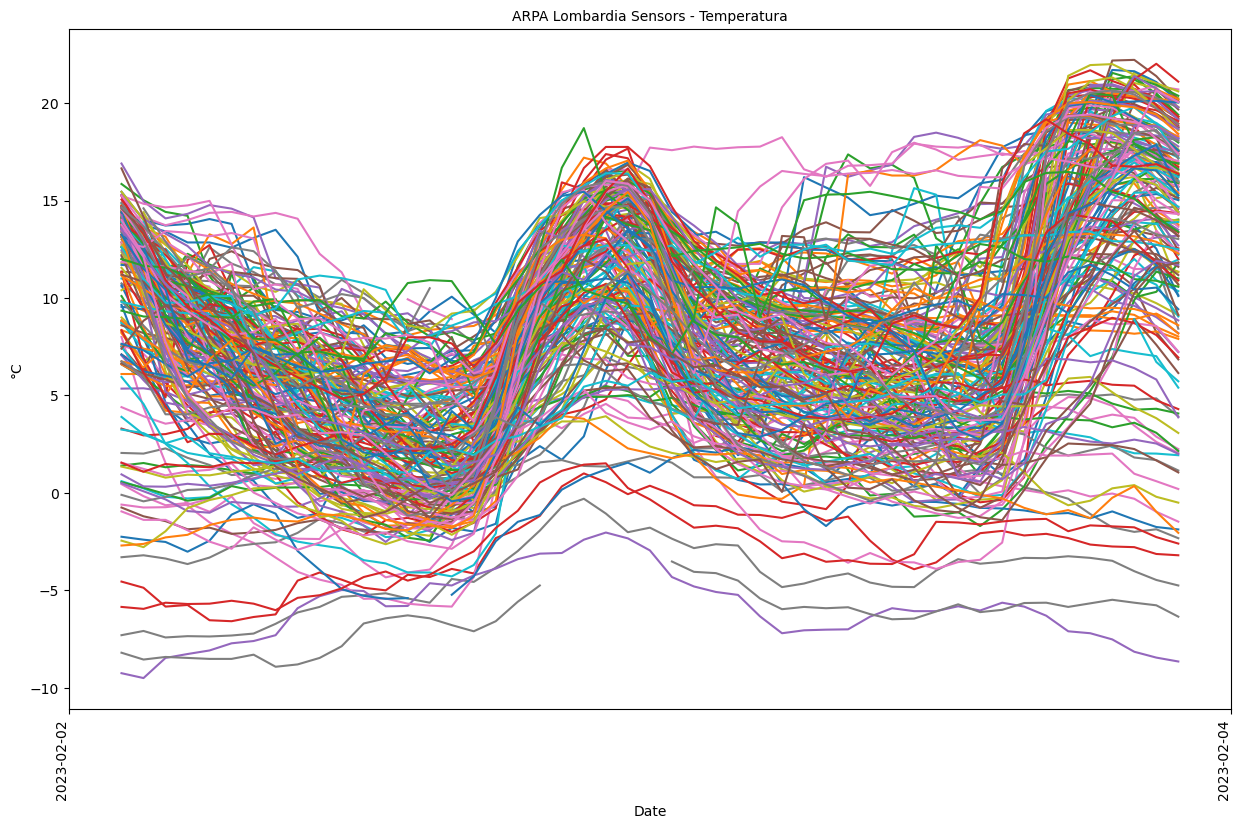

In [190]:
# Create a new figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('ARPA Lombardia Sensors - '+ sensor_sel,fontdict = {'fontsize': 10})
ax.set_ylabel(measure_unit,fontdict = {'fontsize': 10})
ax.set_xlabel('Date',fontdict = {'fontsize': 10})
# Iterate over the sensor IDs
for sensor_id in sensors_list:
    # Get the data for the current sensor
    sensor_data = merged_df[merged_df['idsensore'] == sensor_id]
    # Plot the time series for the sensor
    ax.plot(sensor_data['data'], sensor_data[stat_sel], label=sensor_id)

# # Add a legend to the plot
# ax.legend()

# Show the plot
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.show()

### Check highest and lowest values

Select the sensor that provide the lowest value in the dataframe to check if there are possible errors:

In [191]:
min_index = merged_df[stat_sel].idxmin()
idsensor_min = merged_df.loc[min_index].idsensore
sel_sensor_min = merged_df.loc[merged_df['idsensore']==idsensor_min]
data_min = merged_df.loc[min_index]['data']
merged_df.loc[min_index]

idsensore                                                    14221
data                                           2023-02-02 17:00:00
mean                                                          -9.5
max                                                           -9.2
min                                                           -9.8
std                                                       0.260768
count                                                            6
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                    1343
nomestazione                               Lanzada Passo Marinelli
quota                                                         3032
provincia                                                       SO
datastart                                      2012-10-13 00:00:00
storico                                                       

Select the sensor that provide the highest value in the dataframe:

In [192]:
max_index = merged_df[stat_sel].idxmax()
idsensor_max = merged_df.loc[max_index].idsensore
sel_sensor_max = merged_df.loc[merged_df['idsensore']==idsensor_max]
data_max = merged_df.loc[max_index]['data']
merged_df.loc[max_index]

idsensore                                                     5910
data                                           2023-02-04 14:00:00
mean                                                     22.216667
max                                                           22.5
min                                                           22.0
std                                                        0.17224
count                                                            6
tipologia                                              Temperatura
unit_dimisura                                                   °C
idstazione                                                     535
nomestazione                                 Lacchiarella v.Molise
quota                                                           97
provincia                                                       MI
datastart                                      1998-09-15 00:00:00
storico                                                       

Plot min and max selected sensors:

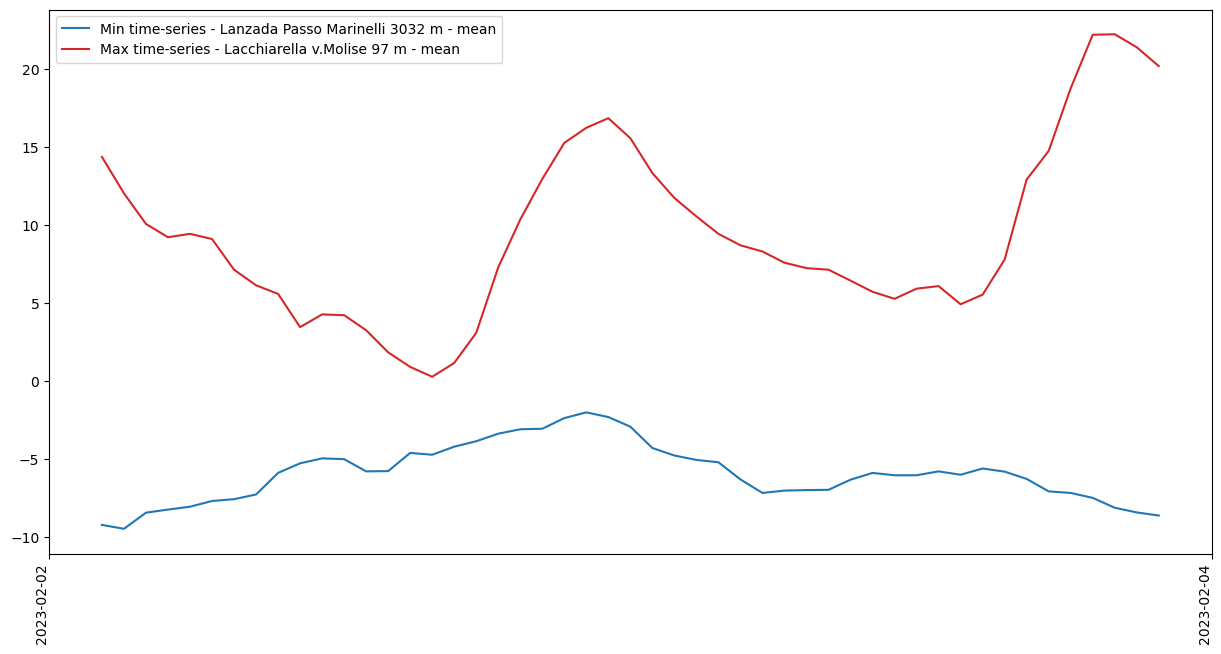

In [210]:
plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor_min['data'],sel_sensor_min[stat_sel], '-',  color="tab:blue", label=("Min time-series - {nome} {quota} m").format(nome=sel_sensor_min["nomestazione"].unique()[0], quota=sel_sensor_min["quota"].unique()[0]) + " - " + stat_sel)
plt.plot(sel_sensor_max['data'],sel_sensor_max[stat_sel], '-',  color="tab:red", label=("Max time-series - {nome} {quota} m").format(nome=sel_sensor_max["nomestazione"].unique()[0], quota=sel_sensor_max["quota"].unique()[0]) + " - " + stat_sel)
plt.legend()

### Box Plot

Text(1, 23.21666717529297, 'ID: 14221, Quota: 3032 m\n Lanzada Passo Marinelli\n mean')

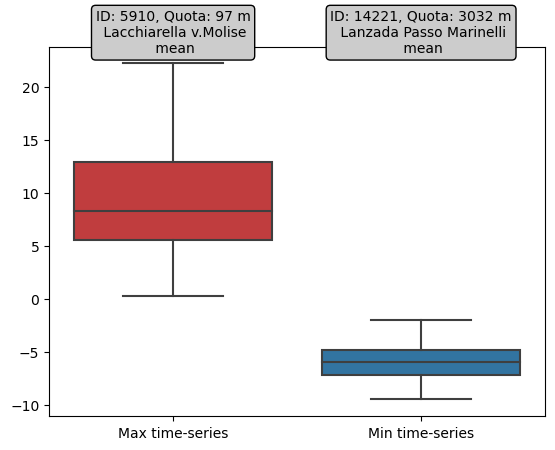

In [211]:
my_pal = {0: "tab:red", 1: "tab:blue"}
box = sns.boxplot(data=[sel_sensor_max[stat_sel], sel_sensor_min[stat_sel]], orient="v", palette=my_pal)
plt.xticks([0, 1],["Max time-series","Min time-series"])
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}\n {stat}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0], stat=stat_sel),
             xy=(0, sel_sensor_max[stat_sel].max()+1),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))
box.annotate(("ID: {id}, Quota: {quota} m\n {nome}\n {stat}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0], stat=stat_sel),
             xy=(1, sel_sensor_max[stat_sel].max()+1),
             horizontalalignment='center',
             bbox=dict(boxstyle="round", fc="0.8"))

### Map

In [212]:
import geopandas as gpd 

Import Lombardy and CMM vector files:

In [213]:
lombardy_gdf = gpd.read_file('lombardia_boundary.gpkg')
cmm_gdf = gpd.read_file('CMM.gpkg')

Convert to Geodataframe:

In [214]:
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.cgb_est, merged_df.cgb_nord), crs="EPSG:32632")

In [215]:
gdf.head()

idsensore                data      mean  max  min       std  count  \
0         53 2023-02-02 16:00:00 -0.100000  0.0 -0.2  0.141421      2   
1         53 2023-02-02 17:00:00 -0.433333 -0.3 -0.5  0.081650      6   
2         53 2023-02-02 18:00:00 -0.200000  0.1 -0.5  0.236643      6   
3         53 2023-02-02 19:00:00  0.150000  0.2  0.0  0.083666      6   
4         53 2023-02-02 20:00:00  0.200000  0.4  0.0  0.126491      6   

     tipologia unit_dimisura  idstazione  ... provincia  datastart storico  \
0  Temperatura            °C          28  ...        SO 1989-10-28       N   
1  Temperatura            °C          28  ...        SO 1989-10-28       N   
2  Temperatura            °C          28  ...        SO 1989-10-28       N   
3  Temperatura            °C          28  ...        SO 1989-10-28       N   
4  Temperatura            °C          28  ...        SO 1989-10-28       N   

  cgb_nord cgb_est                lng                lat  \
0  5130098  564213  9.834123382219671  46.32141528836431   
1  5130098  564213  9.834123382219671  46.32141528836431   
2  5130098  564213  9.834123382219671  46.32141528836431   
3  5130098  564213  9.834123382219671  46.32141528836431   
4  5130098  564213  9.834123382219671  46.32141528836431   

                                            location datastop  \
0  {'latitude': '46.32141528836431', 'longitude':...      NaT   
1  {'latitude': '46.32141528836431', 'longitude':...      NaT   
2  {'latitude': '46.32141528836431', 'longitude':...      NaT   
3  {'latitude': '46.32141528836431', 'longitude':...      NaT   
4  {'latitude': '46.32141528836431', 'longitude':...      NaT   

                         geometry  
0  POINT (564213.000 5130098.000)  
1  POINT (564213.000 5130098.000)  
2  POINT (564213.000 5130098.000)  
3  POINT (564213.000 5130098.000)  
4  POINT (564213.000 5130098.000)  

[5 rows x 22 columns]

Filter on the dates corresponding to the max and min values found before:

In [216]:
min_date = merged_df.loc[min_index].data
max_date =merged_df.loc[max_index].data

In [217]:
min_date, max_date

(Timestamp('2023-02-02 17:00:00'), Timestamp('2023-02-04 14:00:00'))

In [218]:
max_gdf = gdf.loc[merged_df['data'] == max_date]
min_gdf = gdf.loc[merged_df['data'] == min_date]

In [219]:
min_point = min_gdf.loc[min_gdf['idsensore'] == idsensor_min]
max_point = max_gdf.loc[max_gdf['idsensore'] == idsensor_max]

Text(0.5, 173.14773259505725, 'East [m]')

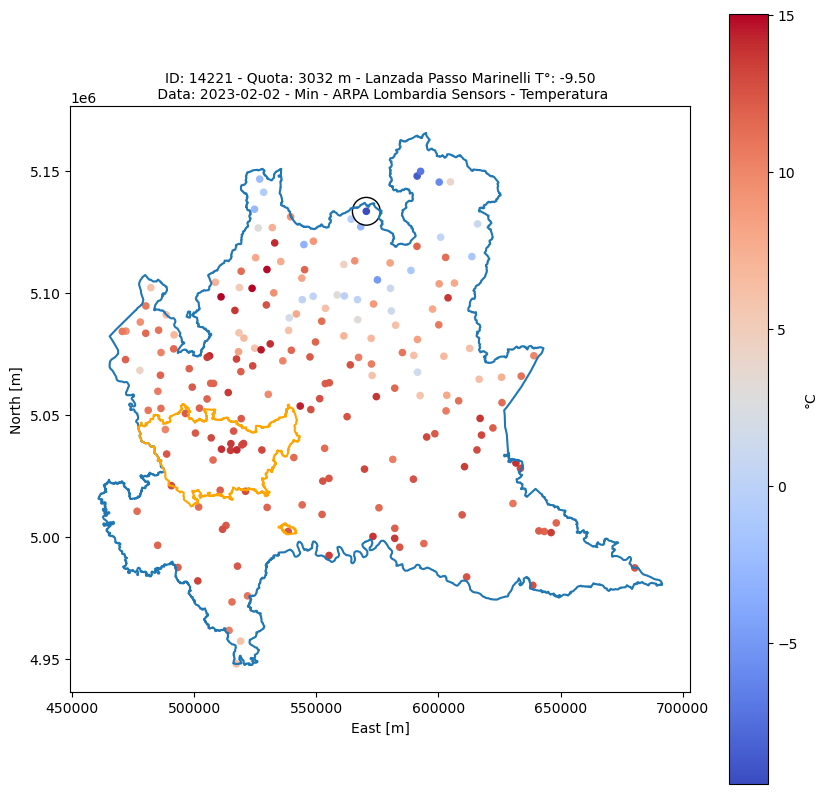

In [222]:
fig, ax = plt.subplots(figsize = (10,10))
min_gdf.plot(ax=ax, markersize=20, column=stat_sel, legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
min_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m - {nome} T°: {minT:0.2f}\n Data: {data} - Min - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_min["idsensore"].unique()[0],
             quota=sel_sensor_min["quota"].unique()[0], nome=sel_sensor_min["nomestazione"].unique()[0], minT=sel_sensor_min[stat_sel].min(),
             data=data_min.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

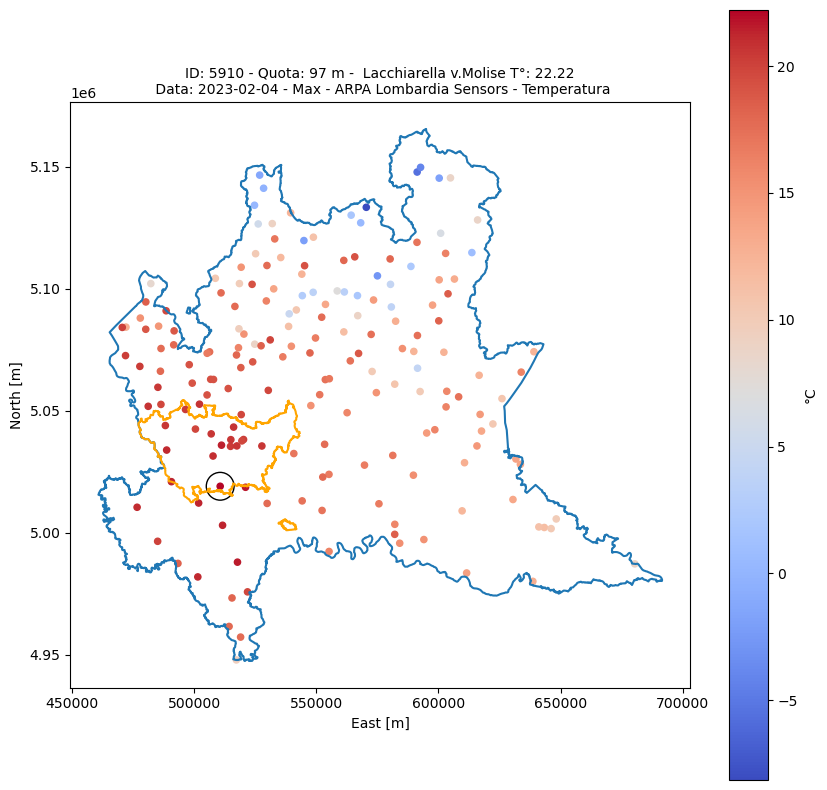

In [223]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column=stat_sel, legend=True, cmap='coolwarm', legend_kwds={'label': measure_unit ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
max_point.plot(ax=ax, marker='o', markersize=400, color='black',facecolors='none')
ax.set_title(("ID: {id} - Quota: {quota} m -  {nome} T°: {maxT:0.2f}\n Data: {data} - Max - ARPA Lombardia Sensors - {sensor_sel}").format(id=sel_sensor_max["idsensore"].unique()[0],
             quota=sel_sensor_max["quota"].unique()[0], nome=sel_sensor_max["nomestazione"].unique()[0], maxT=sel_sensor_max[stat_sel].max(),
             data=data_max.strftime("%Y-%m-%d"), sensor_sel=sensor_sel), fontdict = {'fontsize': 10})

ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

Text(0.5, 173.14773259505725, 'East [m]')

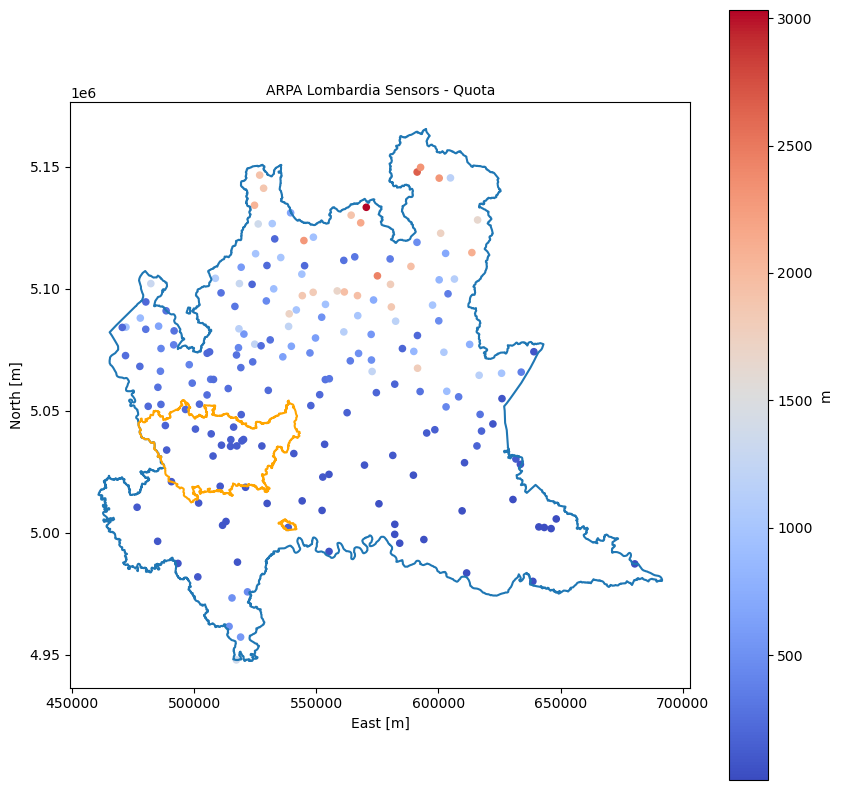

In [224]:
fig, ax = plt.subplots(figsize = (10,10))
max_gdf.plot(ax=ax, markersize=20, column='quota', legend=True, cmap='coolwarm', legend_kwds={'label': 'm' ,'orientation': "vertical"});
lombardy_gdf.boundary.plot(ax=ax);
cmm_gdf.boundary.plot(ax=ax, edgecolor='orange');
ax.set_title('ARPA Lombardia Sensors - Quota',fontdict = {'fontsize': 10})
ax.set_ylabel('North [m]',fontdict = {'fontsize': 10})
ax.set_xlabel('East [m]',fontdict = {'fontsize': 10})

In [225]:
gdf_test = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.lng, merged_df.lat), crs="EPSG:4326")

In [226]:
gdf_test.dtypes

idsensore                 int64
data             datetime64[ns]
mean                    float32
max                     float32
min                     float32
std                     float64
count                     int64
tipologia              category
unit_dimisura            object
idstazione                int32
nomestazione             object
quota                     int16
provincia              category
datastart        datetime64[ns]
storico                category
cgb_nord                 object
cgb_est                  object
lng                      object
lat                      object
location                 object
datastop         datetime64[ns]
geometry               geometry
dtype: object

In [234]:
gdf_test.head()

idsensore                data      mean  max  min       std  count  \
0         53 2023-02-02 16:00:00 -0.100000  0.0 -0.2  0.141421      2   
1         53 2023-02-02 17:00:00 -0.433333 -0.3 -0.5  0.081650      6   
2         53 2023-02-02 18:00:00 -0.200000  0.1 -0.5  0.236643      6   
3         53 2023-02-02 19:00:00  0.150000  0.2  0.0  0.083666      6   
4         53 2023-02-02 20:00:00  0.200000  0.4  0.0  0.126491      6   

     tipologia unit_dimisura  idstazione  ... provincia  datastart storico  \
0  Temperatura            °C          28  ...        SO 1989-10-28       N   
1  Temperatura            °C          28  ...        SO 1989-10-28       N   
2  Temperatura            °C          28  ...        SO 1989-10-28       N   
3  Temperatura            °C          28  ...        SO 1989-10-28       N   
4  Temperatura            °C          28  ...        SO 1989-10-28       N   

  cgb_nord cgb_est                lng                lat  \
0  5130098  564213  9.834123382219671  46.32141528836431   
1  5130098  564213  9.834123382219671  46.32141528836431   
2  5130098  564213  9.834123382219671  46.32141528836431   
3  5130098  564213  9.834123382219671  46.32141528836431   
4  5130098  564213  9.834123382219671  46.32141528836431   

                                            location datastop  \
0  {'latitude': '46.32141528836431', 'longitude':...      NaT   
1  {'latitude': '46.32141528836431', 'longitude':...      NaT   
2  {'latitude': '46.32141528836431', 'longitude':...      NaT   
3  {'latitude': '46.32141528836431', 'longitude':...      NaT   
4  {'latitude': '46.32141528836431', 'longitude':...      NaT   

                   geometry  
0  POINT (9.83412 46.32142)  
1  POINT (9.83412 46.32142)  
2  POINT (9.83412 46.32142)  
3  POINT (9.83412 46.32142)  
4  POINT (9.83412 46.32142)  

[5 rows x 22 columns]

In [228]:
min_gdf["lat"] = [float(str(i).replace(",", "")) for i in min_gdf["lat"]]
min_gdf["lng"] = [float(str(i).replace(",", "")) for i in min_gdf["lng"]]

In [229]:
max_gdf["lat"] = [float(str(i).replace(",", "")) for i in max_gdf["lat"]]
max_gdf["lng"] = [float(str(i).replace(",", "")) for i in max_gdf["lng"]]

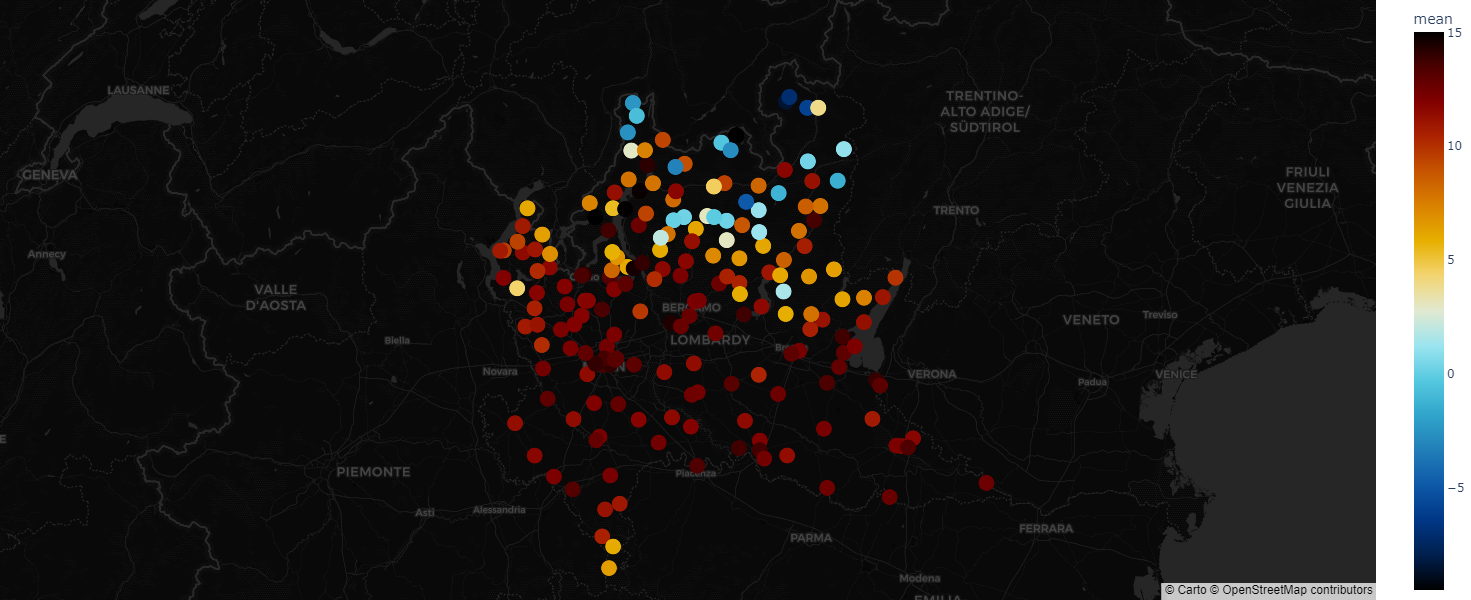

In [232]:
#using plotly for an animated choropleth map
import plotly.express as px
fig = px.scatter_mapbox(min_gdf,
                        lat="lat",
                        lon="lng",
                        hover_name="idsensore",
                        hover_data=["nomestazione","provincia",stat_sel],
                        color=stat_sel,
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=7,
                        height=600,
                        size='lat',
                        size_max=12,
                        opacity=1,
                        width=900)
fig.update_layout(mapbox_style='carto-darkmatter')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

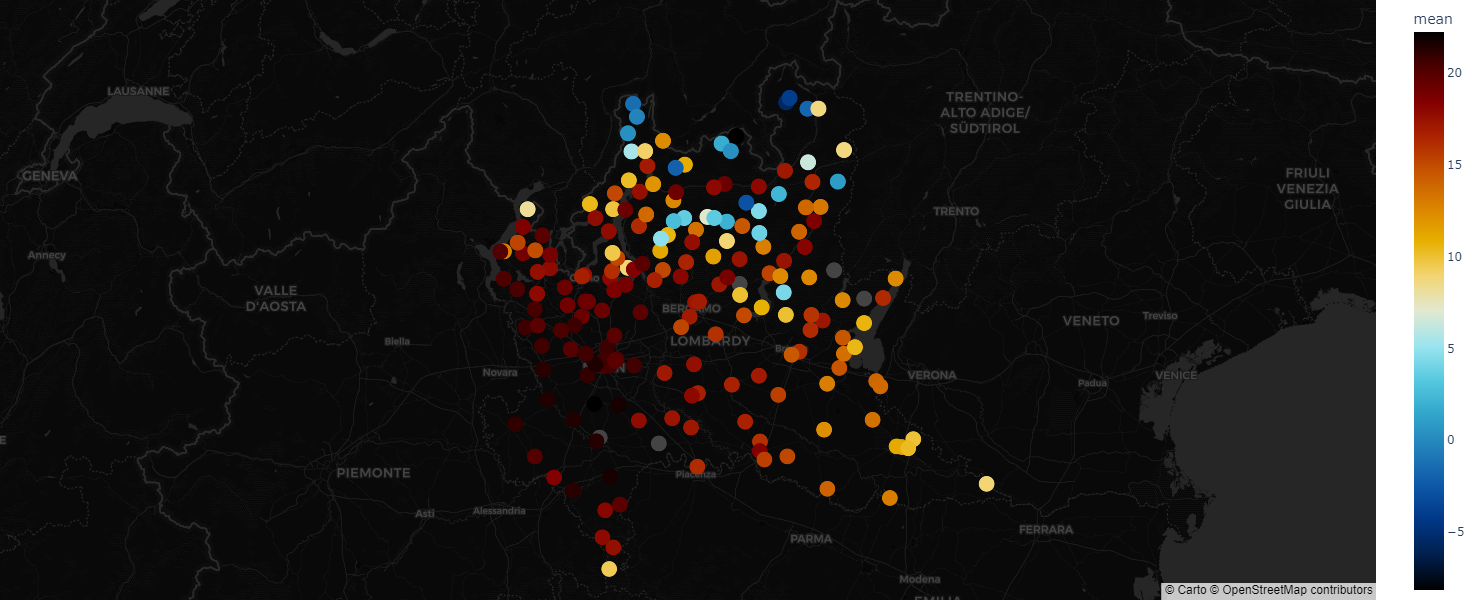

In [233]:
fig = px.scatter_mapbox(max_gdf,
                        lat="lat",
                        lon="lng",
                        hover_name="idsensore",
                        hover_data=["nomestazione","provincia",stat_sel],
                        color=stat_sel,
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=7,
                        height=600,
                        size='lat',
                        size_max=12,
                        opacity=1,
                        width=900)
fig.update_layout(mapbox_style='carto-darkmatter')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

Interactive map (use a small geodataframe)

In [ ]:
# gdf_test = gdf
# gdf_test['data'] = gdf_test['data'].astype(str)
# gdf_test = gdf_test.drop(['datastart','datastop'], axis=1)
# m = gdf_test.explore(
#      column="valore",  # make choropleth based on "BoroName" column
#      cmap='OrRd',
#      scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
#      legend=True, # show legend
#      k=10, # use 10 bins
#      legend_kwds=dict(colorbar='OrRd'), # do not use colorbar
#      name="stations") # name of the layer in the map

# lombardy_gdf.explore(m=m,
#                     style_kwds=dict(fill=False))

## Other useful functions

In [ ]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [ ]:
# remove_csv_file(csv_file)

In [ ]:
# from scipy import stats

# def zscore_filter(df, zscore_tr=3):

#     grouped = df.groupby('idsensore')
    
#     # for each group, calculate the z-scores and remove the outliers
#     for name, group in grouped:
#         df['z_scores'] = stats.zscore(group['valore'], nan_policy='omit')
#         df = df[(df['idsensore'] != name) | (df['z_scores'].abs() <= zscore_tr)]
 
#     return df

In [ ]:
# # backup 
#     #Create list of sensor integer
#     sens_list = list(map(int, sens_list_str))
    
#     #Create sensors list formatted for query
#     ids_str = ""
#     for i in sens_list:
#         ids_str += f"\'{str(i)}\',"
#     ids_str = ids_str[:-1]
#     ids_str += ""
    
#     #Select the Open Data Lombardia Meteo sensors dataset
#     weather_sensor_id = "647i-nhxk"
    
#     #Convert to string in year-month-day format, accepted by ARPA query
#     start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
#     end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
#     print("--- Starting request to ARPA API ---")
    
#     t = time.time()
    
#     #Query data
#     query = """
#       select
#           *
#       where data >= \'{}\' and data <= \'{}\' and idsensore in ({}) limit 9999999999999999
#       """.format(start_date, end_date, ids_str)

In [ ]:
# sensors_provinces = sensors_df.groupby('provincia')['idsensore'].apply(list).to_frame().reset_index() #sensors lists grouped by province

## APPENDIX: Additional material

Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py